<a href="https://colab.research.google.com/github/Julio-M39/pix2pix-cGAN-Mapas/blob/main/pix2pix_(cGAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cGAN com pix2pix 


## Importação das bibliotecas

In [1]:
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display
import tensorflow as tf
tf.__version__

'2.9.2'

In [2]:
tf.random.set_seed(789)

## Download do dataset

In [3]:
dataset = 'maps'



Outros datasets além do `maps`: 
* `cityscapes`
* `edges2handbags`
* `edges2shoes`
* `facades`
* `night2day`

(https://github.com/affinelayer/pix2pix-tensorflow#datasets-and-trained-models)

In [5]:
arquivo_dataset = "{}.tar.gz".format(dataset)
url_dataset = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{}".format(arquivo_dataset)
print(url_dataset)

http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz


In [6]:
download_zip = tf.keras.utils.get_file(fname = arquivo_dataset, origin = url_dataset, extract = True)

250242400/250242400 [==============================] - 246s 1us/step


In [7]:
download_zip = pathlib.Path(download_zip)
caminho = download_zip.parent/dataset

In [8]:
caminho

PosixPath('/root/.keras/datasets/maps')

In [9]:
list(caminho.parent.iterdir())

[PosixPath('/root/.keras/datasets/maps'),
 PosixPath('/root/.keras/datasets/maps.tar.gz')]

In [10]:
amostra = tf.io.read_file(str(caminho / 'train/2.jpg'))
amostra = tf.io.decode_jpeg(amostra)

(600, 1200, 3)


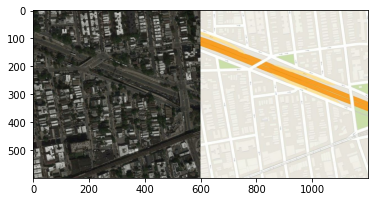

In [11]:
print(amostra.shape)
plt.figure()
plt.imshow(amostra);

## Funções para pré-processamento

In [12]:
def carregar_imagem(img_arquivo):
  img = tf.io.read_file(img_arquivo)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, [256, 512])

  largura = tf.shape(img)[1]
  largura = largura // 2
  img_original = img[:, :largura, :]
  img_transformada = img[:, largura:, :]

  img_original = tf.cast(img_original, tf.float32)
  img_transformada = tf.cast(img_transformada, tf.float32)

  return img_original, img_transformada

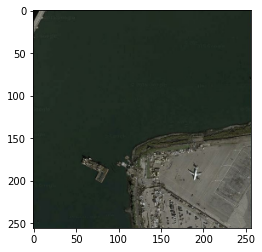

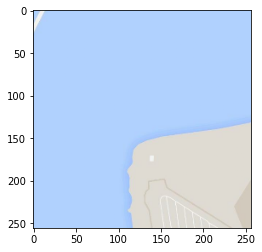

In [13]:
img_original, img_transformada = carregar_imagem(str(caminho / 'train/110.jpg'))
plt.figure()
plt.imshow(img_original / 255.0)
plt.figure()
plt.imshow(img_transformada / 255.0);

In [14]:
qtd_treinamento = tf.data.Dataset.list_files(str(caminho / 'train/*.jpg'))
qtd_treinamento

<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [15]:
qtd_treinamento = len(list(qtd_treinamento))
qtd_treinamento

1096

In [16]:
buffer_size = qtd_treinamento
batch_size = 1
img_largura = 256
img_altura = 256

In [17]:
def redimensionar(img_original, img_transformada, altura, largura):
  img_original = tf.image.resize(img_original, [altura, largura], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  img_transformada = tf.image.resize(img_transformada, [altura, largura], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return img_original, img_transformada

In [18]:
def normalizar(img_original, img_transformada):
  img_original = (img_original / 127.5) - 1
  img_transformada = (img_transformada / 127.5) - 1
  return img_original, img_transformada

In [19]:
def crop_aleatorio(img_original, img_transformada):
  img_empilhada = tf.stack([img_original, img_transformada], axis = 0)
  img_crop = tf.image.random_crop(img_empilhada, size = [2, img_altura, img_largura, 3])
  return img_crop[0], img_crop[1]

In [20]:
tf.random.uniform(())

<tf.Tensor: shape=(), dtype=float32, numpy=0.3231734>

In [21]:
@tf.function()
def jitter_aleatorio(img_original, img_transformada):
  img_original, img_transformada = redimensionar(img_original, img_transformada, 286, 286)
  img_original, img_transformada = crop_aleatorio(img_original, img_transformada)
  if tf.random.uniform(()) > 0.5:
    img_original = tf.image.flip_left_right(img_original)
    img_transformada = tf.image.flip_left_right(img_transformada)
  return img_original, img_transformada

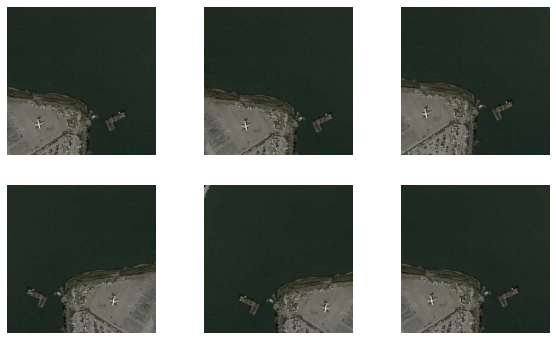

In [22]:
plt.figure(figsize=(10,6))
for i in range(6):
  j_original, j_transformada = jitter_aleatorio(img_original, img_transformada)
  plt.subplot(2,3, i + 1)
  plt.imshow(j_original / 255.0)
  plt.axis('off')
plt.show()

## Carregamento do dataset


In [23]:
def carrega_img_treinamento(img_arquivo):
  img_original, img_transformada = carregar_imagem(img_arquivo)
  img_original, img_transformada = jitter_aleatorio(img_original, img_transformada)
  img_original, img_transformada = normalizar(img_original, img_transformada)
  return img_original, img_transformada

In [24]:
def carrega_img_teste(img_arquivo):
  img_original, img_transformada = carregar_imagem(img_arquivo)
  img_original, img_transformada = redimensionar(img_original, img_transformada, img_altura, img_largura)
  img_original, img_transformada = normalizar(img_original, img_transformada)
  return img_original, img_transformada

In [25]:
dataset_treinamento = tf.data.Dataset.list_files(str(caminho / 'train/*.jpg'))
dataset_treinamento = dataset_treinamento.map(carrega_img_teste, num_parallel_calls=tf.data.AUTOTUNE)
dataset_treinamento = dataset_treinamento.shuffle(buffer_size)
dataset_treinamento = dataset_treinamento.batch(batch_size)

In [26]:
dataset_treinamento

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None))>

In [27]:
try:
  dataset_teste = tf.data.Dataset.list_files(str(caminho / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  dataset_teste = tf.data.Dataset.list_files(str(caminho / 'val/*.jpg'))
dataset_teste = dataset_teste.map(carrega_img_teste)
dataset_teste = dataset_teste.batch(batch_size)

## Gerador

O gerador que vamos construir para a cGAN Pix2Pix é uma [U-Net](https://paperswithcode.com/method/u-net) modificada. 

Uma U-Net consiste basicamente: 
* Encoder - Parte de Contração (downsampler) 
* Decoder - Parte de Expansão (upsampler)

Mais sobre arquitetura U-Net: 
* https://paperswithcode.com/method/u-net
* https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

**Função de downsample / encode**
 * Convolution -> Batch normalization -> Leaky ReLU

In [28]:
def encode(filters, size, apply_batchnorm = True):
  initializer = tf.random_normal_initializer(0, 0.02)
  resultado = tf.keras.Sequential()
  resultado.add(tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same', 
                                       kernel_initializer=initializer, use_bias = False))
  if apply_batchnorm:
    resultado.add(tf.keras.layers.BatchNormalization())
  
  resultado.add(tf.keras.layers.LeakyReLU())

  return resultado

In [29]:
down_model = encode(3, 4)
down_result = down_model(tf.expand_dims(img_original, 0))
print(down_result.shape)

(1, 128, 128, 3)


**Função de upsample / decode**
 * Transposed convolution -> Batch normalization -> Dropout (aplicado aos 3 primeiros blocos) -> ReLU

In [30]:
def decode(filters, size, apply_dropout = False):
  initializer = tf.random_normal_initializer(0, 0.02)
  resultado = tf.keras.Sequential()
  resultado.add(tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same', 
                                                kernel_initializer=initializer, use_bias = False))
  resultado.add(tf.keras.layers.BatchNormalization())
  
  if apply_dropout:
    resultado.add(tf.keras.layers.Dropout(0.5))
  
  resultado.add(tf.keras.layers.ReLU())

  return resultado

In [31]:
up_model = decode(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [32]:
def Gerador():
  inputs = tf.keras.layers.Input(shape = [256, 256, 3])

  downsampling = [
      encode(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
      encode(128, 4),  # (batch_size, 64, 64, 128)
      encode(256, 4),  # (batch_size, 32, 32, 256)
      encode(512, 4),  # (batch_size, 16, 16, 512)
      encode(512, 4),  # (batch_size, 8, 8, 512)
      encode(512, 4),  # (batch_size, 4, 4, 512)
      encode(512, 4),  # (batch_size, 2, 2, 512)
      encode(512, 4),  # (batch_size, 1, 1, 512)
  ]

  upsampling = [
      decode(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 512)
      decode(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 512)
      decode(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 512)
      decode(512, 4),  # (batch_size, 16, 16, 512)
      decode(256, 4),  # (batch_size, 32, 32, 256)
      decode(128, 4),  # (batch_size, 64, 64, 128)
      decode(64, 4),  # (batch_size, 128, 128, 64)
  ]

  canais_saida = 3
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(canais_saida, 4, strides=2, padding='same', 
                                         kernel_initializer=initializer, activation = 'tanh')  # (batch_size, 256, 256, 3)

  x = inputs
  skips = []
  for down in downsampling:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(upsampling, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)
  return tf.keras.Model(inputs = inputs, outputs = x)


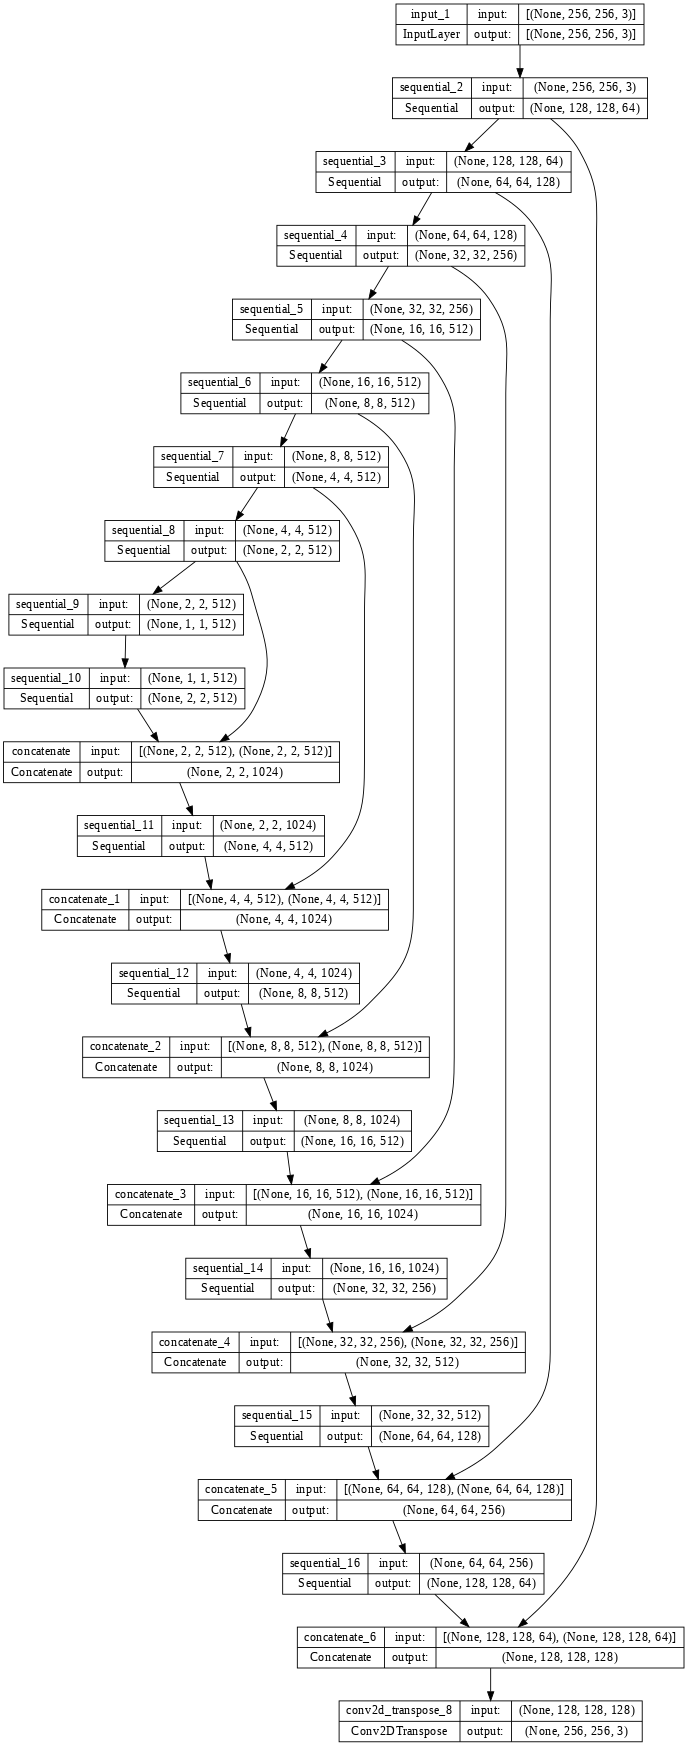

In [33]:
gerador = Gerador()
tf.keras.utils.plot_model(gerador, show_shapes = True, dpi = 64)

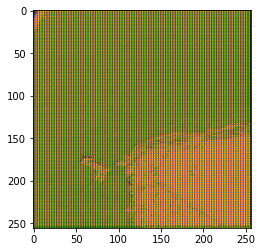

In [34]:
g_saida = gerador(img_original[tf.newaxis, ...], training=False)
plt.imshow(g_saida[0, ...])

### Perda do Gerador

As GANs normais aprendem a perda que adapta-se aos dados, enquanto que a cGAN aprende uma perda estruturada que penaliza uma possível estrutura que difere da saída da rede e da imagem "real" esperada. 
Isso é descrito com mais detalhes no paper do pix2pix https://arxiv.org/abs/1611.07004


> **Hiperparâmetros**

Utilizeramos os hiperparametros sugeridos no paper

* Learning rate: 0.0002
* Momentum: [β1, β2] = [0.5, 0.999]
* Lambda (λ_L1) = 100

Esses parâmetros serão usados na geração da função do loss e na criação do optimizer

In [35]:
lr = 0.0002
beta1, beta2 = 0.5, 0.999
lambda_ = 100

* A perda do gerador é uma sigmoide cross-entropy das imagens geradas e uma array de 1's
* O paper do pix2pix também menciona a perda L1, que é uma MAE (Mean Absolute Error) entre a imagem gerada e a esperada (real).
* Isso garante que a imagem gerada se torne estruturalmente semelhante à imagem real.
* A formula para calculo do total de perda é gan_loss + LAMBDA * l1_loss onde  LAMBDA = 100 - esse valor também é descrito pelos autores do paper. 

In [36]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [37]:
def loss_gerador(d_saida_gerada, g_saida, target):
  gan_loss = loss(tf.ones_like(d_saida_gerada), d_saida_gerada)
  l1_loss = tf.reduce_mean(tf.abs(target - g_saida)) # MAE
  g_loss_total = gan_loss + (lambda_ * l1_loss)
  return g_loss_total, gan_loss, l1_loss

## Discriminador

O discriminador da cGAN Pix2Pix é um classificador [PatchGAN](https://paperswithcode.com/method/patchgan). Seu objetivo é tentar dizer se cada patch (pedaço) da imagem é real ou não.

* Lembrando a formação de cada bloco do discriminador: Convolution -> Batch normalization -> Leaky ReLU.

* O shape da saída após a última camada (last) é `(batch_size, 30, 30, 1)`

Mais detalhes no paper: https://arxiv.org/abs/1611.07004

O discriminador recebe dois inputs:
  1. A imagem de entrada e a imagem esperada, que deveria ser classificada como real 
  2. A imagem de entrada e a imagem gerada (falsa, gerada pelo gerador), que deveria ser classificada como fake/falsa.

In [38]:
def Discriminador():
  initializer = tf.random_normal_initializer(0., 0.02)

  original = tf.keras.layers.Input(shape=[256,256,3], name = 'img_original')
  transformada = tf.keras.layers.Input(shape=[256,256,3], name = 'img_transformada')
  x = tf.keras.layers.concatenate([original, transformada]) # (batch_size, 256, 256, channels*2)

  down1 = encode(64, 4, False)(x) # (batch_size, 128, 128, 64)
  down2 = encode(128, 4)(down1) # (batch_size, 64, 64, 128)
  down3 = encode(256, 4)(down2) # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias = False)(zero_pad1) # (batch_size, 31, 31, 512)
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (batch_size, 33, 33, 512)
  last = tf.keras.layers.Conv2D(1, 4, strides = 1, kernel_initializer=initializer)(zero_pad2) # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs = [original, transformada], outputs = last)

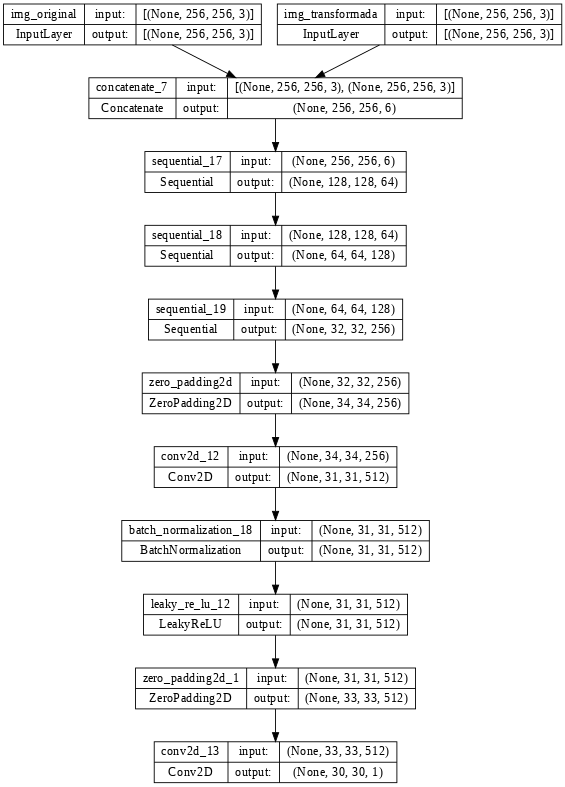

In [39]:
discriminador = Discriminador()
tf.keras.utils.plot_model(discriminador, show_shapes = True, dpi = 64)

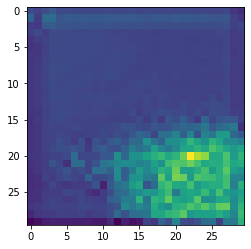

In [40]:
d_saida = discriminador([img_original[tf.newaxis, ...], g_saida], training=False)
plt.imshow(d_saida[0, ..., -1])

### Perda do Discriminador

A loss do discriminador recebe como input:  imagens reais; imagens geradas.
* `loss_real` - sigmoid cross-entropy loss da imagem **real** e uma array de 1's
* `loss_gerada` - sigmoid cross-entropy loss da imagem **gerada** e uma array de 0's 

Por fim, a loss total será a soma de loss_real e loss_gerada

In [41]:
def loss_discriminador(d_saida_real, d_saida_gerada):
  loss_real = loss(tf.ones_like(d_saida_real), d_saida_real)
  loss_gerada = loss(tf.zeros_like(d_saida_gerada), d_saida_gerada)
  d_loss_total = loss_real + loss_gerada
  return d_loss_total

## Optimizers

In [42]:
optimizer_gerador = tf.keras.optimizers.Adam(lr, beta_1=beta1, beta_2=beta2)
optimizer_discriminador = tf.keras.optimizers.Adam(lr, beta_1=beta1, beta_2=beta2)

## Checkpoint do modelo


In [43]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefixo = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = optimizer_gerador,
                                 discriminator_optimizer = optimizer_discriminador,
                                 generator = gerador,
                                 discriminator = discriminador)

## Geração de imagens

In [44]:
def gerar_imagens(modelo, teste_entrada, real, etapa = None):
  gerada = modelo(teste_entrada, training=True)
  plt.figure(figsize=(12,8))

  lista_imgs = [teste_entrada[0], real[0], gerada[0]]
  titulo = ['Imagem de entrada', 'Real (ground truth)', 'Image gerada (fake)']

  for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(titulo[i])
    plt.imshow(lista_imgs[i] * 0.5 + 0.5)
    plt.axis('off')

  if etapa is not None:
    plt.savefig('resultado_pix2pix_etapa_{}.png'.format(etapa), bbox_inches='tight')

  plt.show()

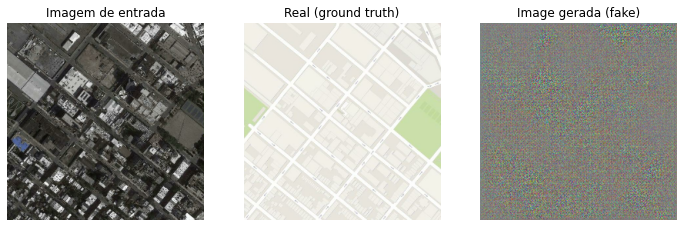

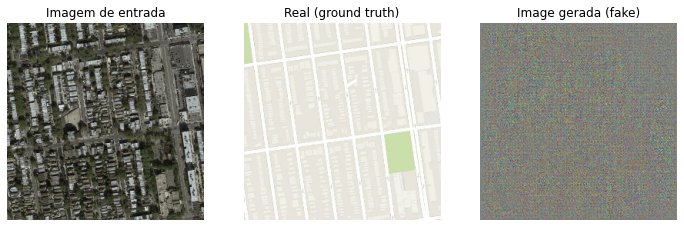

In [45]:
for entrada_exemplo, real_exemplo in dataset_teste.take(2):
  gerar_imagens(gerador, entrada_exemplo, real_exemplo)

## Treinamento

* Para cada entrada gera-se uma saída.
* O discriminador recebe `img_entrada` e as imagens geradas como primeira entrada. A segunda entrada é img_entrada e a "real" (esperada)
* Em seguida, calcula-se a perda do gerador e discriminador (Abaixo definimos uma função para salvar o log) 
* Então calcula-se os gradientes da perda em relação às variáveis do gerador e discriminador (entradas) e aplica essas ao optimizer.

In [46]:
caminho_log = 'logs/'
metricas = tf.summary.create_file_writer(caminho_log + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [47]:
@tf.function
def etapa_treinamento(img_entrada, real, etapa):
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    g_saida = gerador(img_entrada, training = True)

    d_saida_real = discriminador([img_entrada, real], training = True)
    d_saida_gerada = discriminador([img_entrada, g_saida], training = True)

    g_loss_total, g_loss_gan, g_loss_l1 = loss_gerador(d_saida_gerada, g_saida, real)
    d_loss = loss_discriminador(d_saida_real, d_saida_gerada)

  gradients_gerador = g_tape.gradient(g_loss_total, gerador.trainable_variables)
  gradients_discriminador = d_tape.gradient(d_loss, discriminador.trainable_variables)

  optimizer_gerador.apply_gradients(zip(gradients_gerador, gerador.trainable_variables))
  optimizer_discriminador.apply_gradients(zip(gradients_discriminador, discriminador.trainable_variables))

  with metricas.as_default():
    tf.summary.scalar('g_loss_total', g_loss_total, step=etapa//1000)
    tf.summary.scalar('g_loss_gan', g_loss_gan, step=etapa//1000)
    tf.summary.scalar('g_loss_l1', g_loss_l1, step=etapa//1000)
    tf.summary.scalar('d_loss', d_loss, step=etapa//1000)

In [48]:
def treinar(base_treinamento, base_teste, etapas):
  entrada_exemplo, exemplo_real = next(iter(base_teste.take(1)))
  inicio = time.time()

  for etapa, (img_entrada, real) in base_treinamento.repeat().take(etapas).enumerate():
    if etapa % 1000 == 0:
      display.clear_output(wait = True)
      if etapa != 0:
        print(f'Tempo para executar 1000 etapas: {time.time() - inicio:.2f} segundos\n')
      inicio = time.time()
      gerar_imagens(gerador, entrada_exemplo, exemplo_real, etapa)
      print(f"Etapa: {etapa//1000}K")
    etapa_treinamento(img_entrada, real, etapa)
    if (etapa + 1) % 10 == 0:
      print('.', end = '', flush = True)
    if (etapa + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefixo)
      gerador.save_weights('modelo_pix2pix.h5')

Tempo para executar 1000 etapas: 98.91 segundos



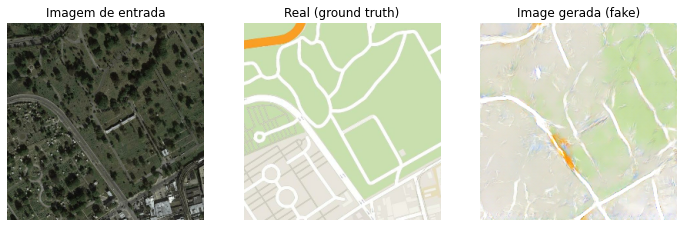

Etapa: 39K
....................................................................................................

In [52]:
treinar(dataset_treinamento, dataset_teste, etapas = 40000)

In [53]:
%reload_ext tensorboard # load
%tensorboard --logdir {caminho_log}

ModuleNotFoundError: ignored

### Observações sobre o treinamento

Algumas coisas para levar em consideração: 

* Note que nem o gerador nem o discriminador "ganham" um do outro. Se ou o `g_loss_gan` ou o `d_loss` estão muito baixos, é um indicador de que este modelo está dominando o outro, o que significa que não está treinando os dois em conjunto como deveria. 

* O valor `log(2) = 0.69` é um bom ponto de referência para essas perdas, pois indica que o discriminador no geral está incerto sobre a sua avaliação (real ou falso)
* Para `d_loss`, um valor abaixo de 0.69 significa que o discriminador está se saindo melhor do que uma classificação aleatória no conjunto combinado de imagens reais e geradas. 
* Para `g_loss_gan`, um valor abaixo de 0.69 significa que o gerador treinado está enganando o discriminador melhor do que se fosse geração aleatória apenas   
* Ao longo do treinamento, `g_loss_l1` deve diminuir. 

## Restauração do checkpoint

In [54]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt-8'

In [55]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Tempo para executar 1000 etapas: 100.10 segundos



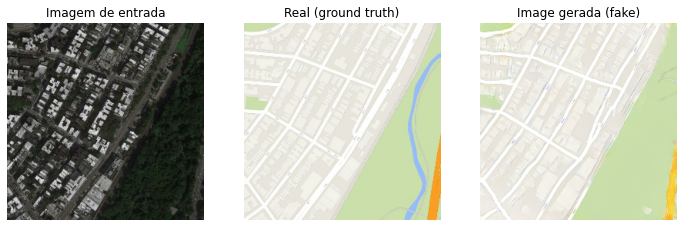

Etapa: 39K
....................................................................................................

In [56]:
treinar(dataset_treinamento, dataset_treinamento, etapas=40000)

In [57]:
modelo_pretreinado = Gerador()
modelo_pretreinado.load_weights('/content/modelo_pix2pix.h5')

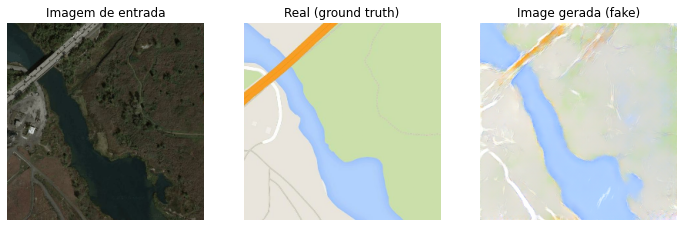

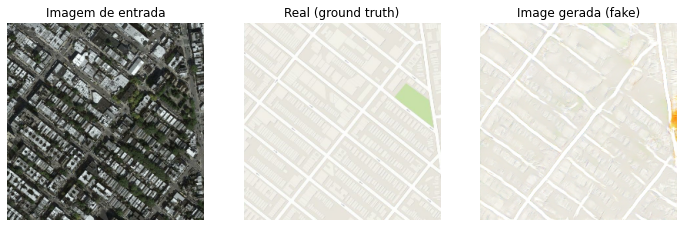

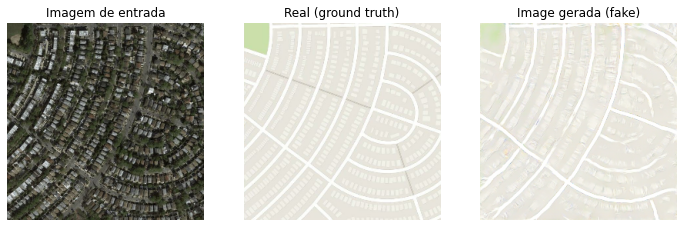

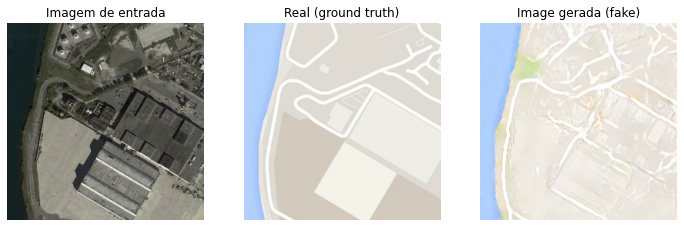

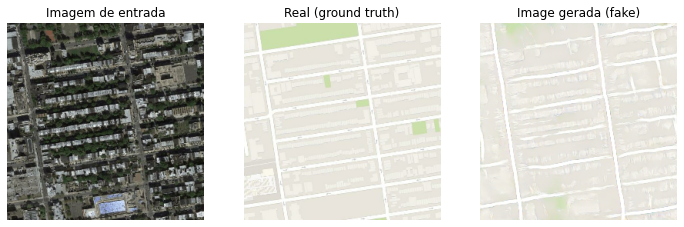

In [59]:
for satelite, mapa in dataset_teste.take(5):
  gerar_imagens(modelo_pretreinado, satelite, mapa)

Códigos de referência:
* https://github.com/affinelayer/pix2pix-tensorflow/blob/master/pix2pix.py
* https://www.tensorflow.org/tutorials/generative/pix2pix
